In [0]:
#to install required dependencies
%pip install pandas matplotlib pyspark

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, avg, round, when,max,min
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML


In [0]:
#ETHUSD file path
ETHUSD_file_path="dbfs:/FileStore/tables/ETHUSDT_trades_2024_01.csv"
#binance file path
binance_file_path="dbfs:/FileStore/tables/cex_trades_binance_ETH_USDT_2024_01.parquet"
#databricks instance ("community.cloud" <-- for me)
databricks_instance_url="https://community.cloud.databricks.com/files" 

In [0]:


# to create an ETH_Trades app
spark = SparkSession.builder.appName("ETH_Trades").getOrCreate()

# to read ETHUSD trades csv file from the databse
df = spark.read.csv(ETHUSD_file_path, 
                     header=False, inferSchema=True).toDF("Timestamp", "Current_Price", 
                     "Transaction_Volume", "Transaction_Value", 
                     "TimeStamp_Mili", "UniSwap1", "UniSwap2")

In [0]:
# to read Binance Trades parquet files
df_Binance = spark.read.parquet(binance_file_path)

In [0]:
# to add column that will act as a base column in joining of the tables
df_Binance = df_Binance.withColumn("TimeStamp_Merge", to_timestamp(col("timestamp") / 1000))
df = df.withColumn("TimeStamp_Merge", to_timestamp(col("TimeStamp_Mili") / 1000))

In [0]:
# to create Uniswap1, Uniswap2 and CowSwap datasets
df_UniSwap1 = df.filter((col("UniSwap1") == True) & (col("UniSwap2") == False))
df_UniSwap2 = df.filter((col("UniSwap1") == False) & (col("UniSwap2") == True))
df_CoSwap = df.filter((col("UniSwap1") == True) & (col("UniSwap2") == True))

In [0]:
# to add this datasets to the storage
df_UniSwap1.coalesce(1).write.csv("dbfs:/FileStore/tables/UniSwap1.csv", header=True, mode="overwrite")
files = dbutils.fs.ls("dbfs:/FileStore/tables/UniSwap1.csv/")
if len(files)>0:
    file_url=databricks_instance_url+files[-1].path.split("FileStore")[-1]
    display(HTML(f'<a href="{file_url}">Download the Uni-Swap1 data file</a>'))


Download the Uni-Swap1 data file

In [0]:

# to add this datasets to the storage
df_UniSwap2.coalesce(1).write.csv("dbfs:/FileStore/tables/UniSwap2.csv", header=True, mode="overwrite")
files=dbutils.fs.ls('dbfs:/FileStore/tables/UniSwap2.csv')
if len(files)>0:
    file_url=databricks_instance_url+files[-1].path.split("FileStore")[-1]
    display(HTML(f'<a href="{file_url}">Download the Uni-Swap2 data file</a>'))


Download the Uni-Swap2 data file

In [0]:
# to add this datasets to the storage
df_CoSwap.coalesce(1).write.csv("dbfs:/FileStore/tables/CoSwap.csv", header=True, mode="overwrite")
files=dbutils.fs.ls("dbfs:/FileStore/tables/CoSwap.csv")
if len(files)>0:
    file_url=databricks_instance_url+files[-1].path.split("FileStore")[-1]
    display(HTML(f'<a href="{file_url}">Download the Co-Swap data file</a>'))

Download the Co-Swap data file

In [0]:

# to merge datasets
df_MergedData = df_Binance.join(df, "TimeStamp_Merge", "inner").drop("timestamp","Timestamp","TimeStamp_Mili")

In [0]:
#to get the price difference between trade price and binance price
df_MergedData = df_MergedData.withColumn("price_difference", round(col("Current_Price") - col("mid_price"),4))


In [0]:
#to show the price difference for each trade
df_MergedData.select("price_difference").show()

+----------------+
|price_difference|
+----------------+
|         -0.0204|
|         -0.0104|
|          0.0104|
|          0.0204|
|          0.0204|
|         -0.0204|
|          0.0204|
|          0.0204|
|          0.0204|
|          0.0204|
|          0.0204|
|          0.0204|
|         -0.0204|
|         -0.0304|
|         -0.0404|
|         -0.0104|
|         -0.0204|
|         -0.0304|
|         -4.0E-4|
|         -0.0104|
+----------------+
only showing top 20 rows



In [0]:
df_MergedData.limit(10).toPandas()

,TimeStamp_Merge,datetime,mid_price,volume,Current_Price,Transaction_Volume,Transaction_Value,UniSwap1,UniSwap2,price_difference
0,2024-01-01 00:00:00.005,2024-01-01 00:00:00.005,2281.859572,31.489944,2281.88,0.0138,31.489944,False,True,0.0204
1,2024-01-01 00:00:02.349,2024-01-01 00:00:02.349,2281.859572,22.818800,2281.88,0.0100,22.818800,False,True,0.0204
2,2024-01-01 00:00:03.242,2024-01-01 00:00:03.242,2281.869572,255.571680,2281.89,0.1120,255.571680,False,True,0.0204
3,2024-01-01 00:00:06.613,2024-01-01 00:00:06.613,2282.149572,646.538761,2282.17,0.2833,646.538761,False,True,0.0204
4,2024-01-01 00:00:07.195,2024-01-01 00:00:07.195,2281.890428,20.080456,2281.87,0.0088,20.080456,True,True,-0.0204
5,2024-01-01 00:00:07.195,2024-01-01 00:00:07.195,2281.890428,20.080456,2281.87,0.0660,150.603420,True,True,-0.0204
6,2024-01-01 00:00:07.195,2024-01-01 00:00:07.195,2281.890428,20.080456,2281.87,0.2114,482.387318,True,True,-0.0204
7,2024-01-01 00:00:07.195,2024-01-01 00:00:07.195,2281.890428,20.080456,2281.87,0.0830,189.395210,True,True,-0.0204
8,2024-01-01 00:00:07.195,2024-01-01 00:00:07.195,2281.890428,150.603420,2281.87,0.0088,20.080456,True,True,-0.0204
9,2024-01-01 00:00:07.195,2024-01-01 00:00:07.195,2281.890428,150.603420,2281.87,0.0660,150.603420,True,True,-0.0204


In [0]:
df_Merge_part=df_MergedData.limit(1000000).toPandas()




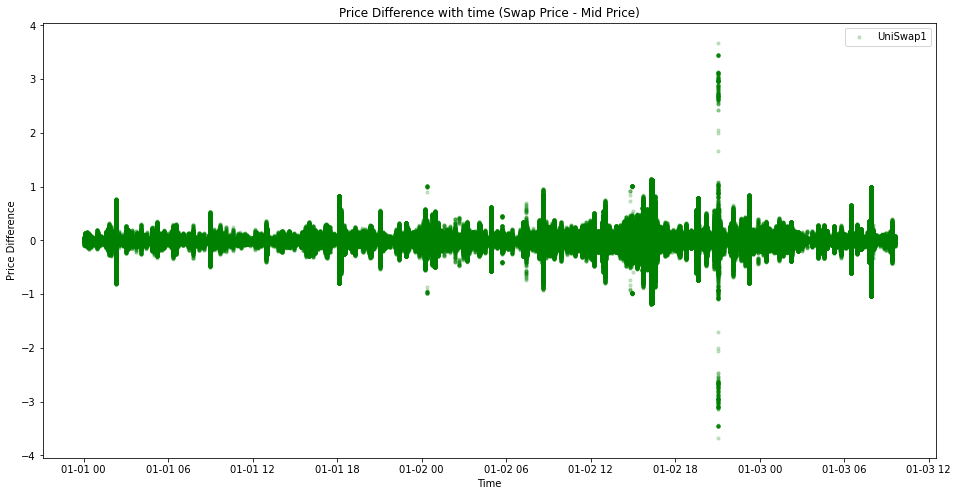

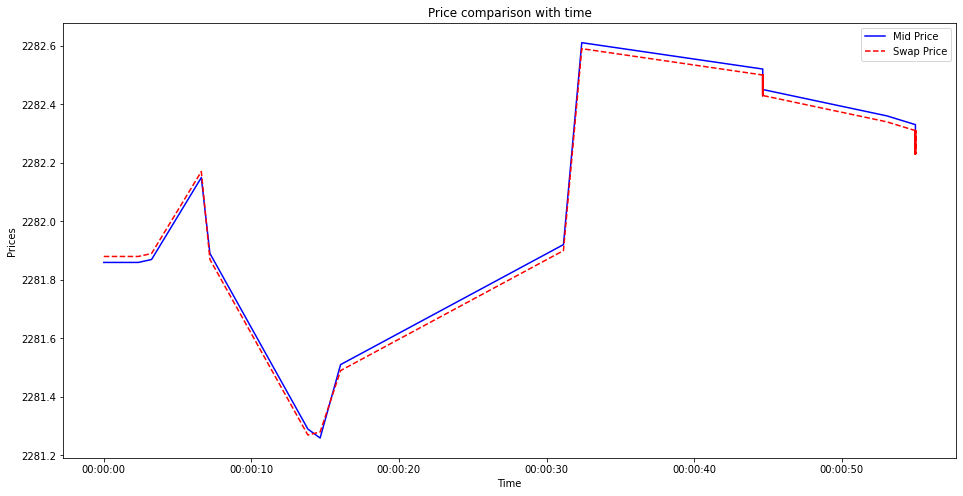

In [0]:
plt.figure(figsize=(16, 8))
df_Merge_part["TimeStamp_Merge"] = pd.to_datetime(df_Merge_part["TimeStamp_Merge"])

plt.scatter(df_Merge_part.head(1000000)["TimeStamp_Merge"], df_Merge_part.head(1000000)["price_difference"], 
               color='green', label="UniSwap1", alpha=0.2, s=10)


plt.xlabel("Time")
plt.ylabel("Price Difference")
plt.title("Price Difference with time (Swap Price - Mid Price)")
plt.legend()
plt.show()

plt.figure(figsize=(16, 8))

plt.plot(df_Merge_part.head(100)["TimeStamp_Merge"], df_Merge_part.head(100)["mid_price"], 
                linestyle="-", color='blue', label="Mid Price", alpha=1)
plt.plot(df_Merge_part.head(100)["TimeStamp_Merge"], df_Merge_part.head(100)["Current_Price"], 
                linestyle="--", color='red', label="Swap Price", alpha=1)


plt.xlabel("Time")
plt.ylabel("Prices")
plt.title("Price comparison with time")
plt.legend()
plt.show()

In [0]:
df_range_uniswap1 = df_UniSwap1.withColumn(
    "Transaction_Value_Range",
    when(col("Transaction_Value")<500,"0-500")
    .when((col("Transaction_Value")<1000) & (col("Transaction_Value")>=500),"500-1000")
    .when((col("Transaction_Value")<1500) & (col("Transaction_Value")>=1000),"1000-1500")
    .when((col("Transaction_Value")<2000) & (col("Transaction_Value")>=1500),"1500-2000")
    .when((col('Transaction_Value')<2500) & (col('Transaction_Value')>=2000),"2000-2500")
    .when((col('Transaction_Value')<3000) & (col('Transaction_Value')>=2500),"2500-3000")
    .when((col('Transaction_Value')<3500) & (col('Transaction_Value')>=3000),"3000-3500")
    .when((col('Transaction_Value')<4000) & (col('Transaction_Value')>=3500),"3500-4000")
    .when((col('Transaction_Value')<4500) & (col('Transaction_Value')>=4000),"4000-4500")
    .otherwise(">=4500"))

In [0]:
df_final_US1=df_range_uniswap1.groupBy("Transaction_Value_Range").agg(avg("Current_Price").alias("avg_current_price"))
df_final_US1=df_final_US1.toPandas()

In [0]:
df_range_uniswap2 = df_UniSwap2.withColumn(
    "Transaction_Value_Range",
    when(col("Transaction_Value")<500,"0-500")
    .when((col("Transaction_Value")<1000) & (col("Transaction_Value")>=500),"500-1000")
    .when((col("Transaction_Value")<1500) & (col("Transaction_Value")>=1000),"1000-1500")
    .when((col("Transaction_Value")<2000) & (col("Transaction_Value")>=1500),"1500-2000")
    .when((col('Transaction_Value')<2500) & (col('Transaction_Value')>=2000),"2000-2500")
    .when((col('Transaction_Value')<3000) & (col('Transaction_Value')>=2500),"2500-3000")
    .when((col('Transaction_Value')<3500) & (col('Transaction_Value')>=3000),"3000-3500")
    .when((col('Transaction_Value')<4000) & (col('Transaction_Value')>=3500),"3500-4000")
    .when((col('Transaction_Value')<4500) & (col('Transaction_Value')>=4000),"4000-4500")
    .otherwise(">=4500"))

In [0]:
df_final_US2=df_range_uniswap2.groupBy("Transaction_Value_Range").agg(avg("Current_Price").alias("avg_current_price"))
df_final_US2=df_final_US2.toPandas()


In [0]:


df_range_cowSwap = df_CoSwap.withColumn(
    "Transaction_Value_Range",
    when(col("Transaction_Value")<500,"0-500")
    .when((col("Transaction_Value")<1000) & (col("Transaction_Value")>=500),"500-1000")
    .when((col("Transaction_Value")<1500) & (col("Transaction_Value")>=1000),"1000-1500")
    .when((col("Transaction_Value")<2000) & (col("Transaction_Value")>=1500),"1500-2000")
    .when((col('Transaction_Value')<2500) & (col('Transaction_Value')>=2000),"2000-2500")
    .when((col('Transaction_Value')<3000) & (col('Transaction_Value')>=2500),"2500-3000")
    .when((col('Transaction_Value')<3500) & (col('Transaction_Value')>=3000),"3000-3500")
    .when((col('Transaction_Value')<4000) & (col('Transaction_Value')>=3500),"3500-4000")
    .when((col('Transaction_Value')<4500) & (col('Transaction_Value')>=4000),"4000-4500")
    .otherwise(">=4500"))



In [0]:
df_final_Co=df_range_cowSwap.groupBy("Transaction_Value_Range").agg(avg("Current_Price").alias("avg_current_price"))
df_final_Co=df_final_Co.toPandas()


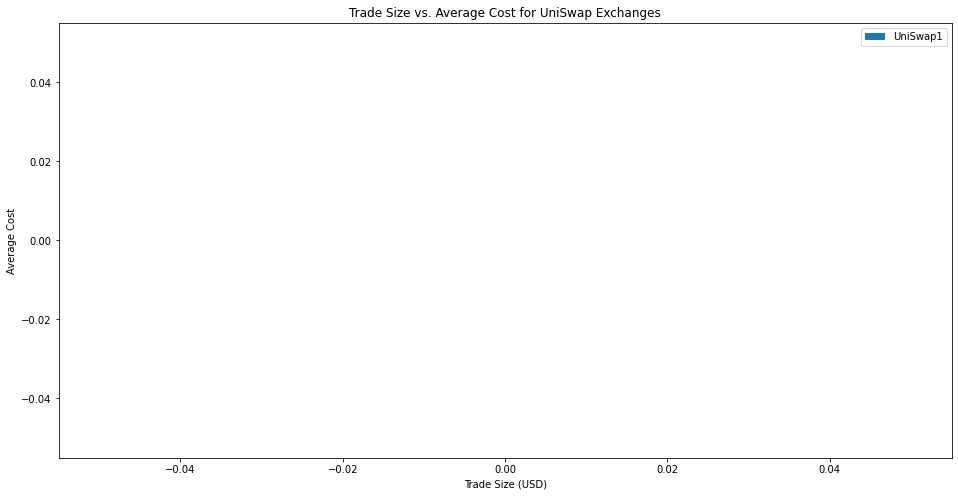

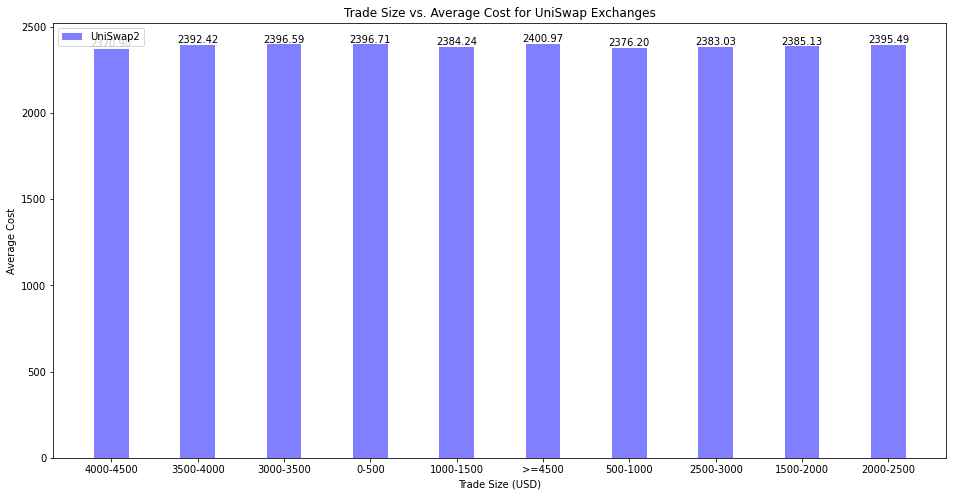

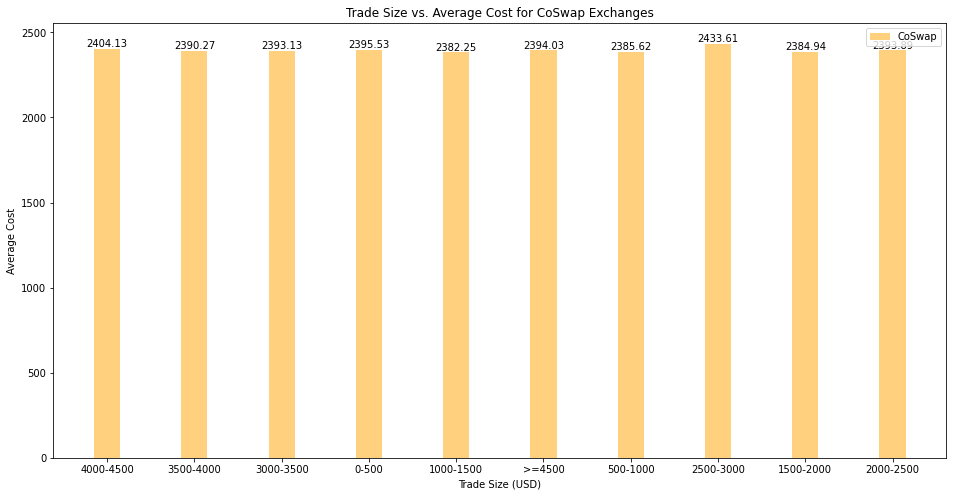

In [0]:
plt.figure(figsize=(16, 8))

bars_U1 = plt.bar(df_final_US1["Transaction_Value_Range"], df_final_US1["avg_current_price"], 
               color='green', label="UniSwap1", alpha=0.5, width=0.3)


# Add values on top of each bar
for bar in bars_U1:
    yval = bar.get_height()  # Get the height of the bar
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom')

plt.xlabel("Trade Size (USD)")
plt.ylabel("Average Cost")
plt.title("Trade Size vs. Average Cost for UniSwap Exchanges")
plt.legend()
plt.show()



# First graph (UniSwap2)
plt.figure(figsize=(16, 8))
bars_U2 = plt.bar(df_final_US2["Transaction_Value_Range"], df_final_US2["avg_current_price"], 
                  color='blue', label="UniSwap2", alpha=0.5, width=0.4)

# Add values on top of each bar
for bar in bars_U2:
    yval = bar.get_height()  # Get the height of the bar
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom')

plt.xlabel("Trade Size (USD)")
plt.ylabel("Average Cost")
plt.title("Trade Size vs. Average Cost for UniSwap Exchanges")
plt.legend()


plt.show()
plt.close() 


# Second graph (CoSwap)
plt.figure(figsize=(16, 8))
bars_Co = plt.bar(df_final_Co["Transaction_Value_Range"], df_final_Co["avg_current_price"], 
                  color='orange', label="CoSwap", alpha=0.5, width=0.3)

# Add values on top of each bar
for bar in bars_Co:
    yval = bar.get_height()  # Get the height of the bar
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom')

plt.xlabel("Trade Size (USD)")
plt.ylabel("Average Cost")
plt.title("Trade Size vs. Average Cost for CoSwap Exchanges")
plt.legend()
plt.show()
plt.close() 
